In [96]:
# 0. Load libraries #

import numpy as np
import pandas as pd
import os, time, warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)
warnings.filterwarnings('ignore')

def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

In [104]:
# 1. Load data #

time1 = time.time()

path = '../input/titanic/train.csv'
df = pd.read_csv(path) 
df.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)
pred=pd.read_csv('../input/titanic/test.csv')
pred.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)

print(df.shape, pred.shape)
df.head()

(891, 9) (418, 8)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


<AxesSubplot:xlabel='Age', ylabel='Survived'>

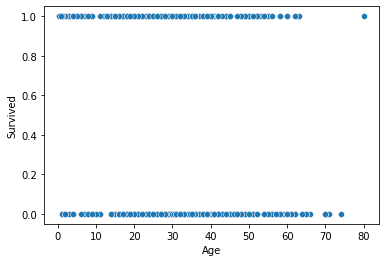

In [105]:
# 2. pEDA #

df.Survived.value_counts()
#df.Age.hist()
sns.scatterplot(x='Age', y='Survived', data=df)

In [106]:
# 3. Train-test split #

df['Age2'] = df['Age']**2
df.drop(columns = ['PassengerId'], inplace = True)
train_y = df[['Survived']]
train_x = df.drop(columns = ['Survived'])

#bin_cols = [col for col in train_x.columns if train_x[col].nunique()==2]
cat_cols = [col for col in train_x.columns if train_x[col].nunique() in range(2,10)]
num_cols = list(set(train_x.columns)-set(cat_cols))

print('categorical features: ', cat_cols, 'numerical features: ', num_cols)

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.2, random_state=3)
print(X_train.shape, X_test.shape, y_train.shape)

X_train.info()

categorical features:  ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'] numerical features:  ['Age', 'Fare', 'Age2']
(712, 8) (179, 8) (712, 1)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 146 to 874
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       568 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  711 non-null    object 
 7   Age2      568 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 50.1+ KB


In [107]:
# 4. Misisng values #

# add dummy for missing Age

X_train.loc[X_train['Age'].isnull(),'misAge']=1
X_train.loc[X_train['Age'].notnull(),'misAge']=0

X_train[num_cols] = X_train[num_cols].fillna(value=X_train[num_cols].median())
X_test[num_cols] = X_test[num_cols].fillna(value=X_train[num_cols].median())
X_train[cat_cols] = X_train[cat_cols].fillna(value=X_train[cat_cols].mode().iloc[0])
X_test[cat_cols] = X_test[cat_cols].fillna(value=X_train[cat_cols].mode().iloc[0])
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 146 to 874
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    object 
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    object 
 7   Age2      712 non-null    float64
 8   misAge    712 non-null    float64
dtypes: float64(4), int64(3), object(2)
memory usage: 55.6+ KB


In [109]:
# extra feature engineering (manual)

X_train['Age_decile'] = pd.qcut(X_train.Age, 15, labels=False, duplicates = 'drop')
cat_cols.extend(['misAge', 'Age_decile'])
X_train.Age_decile.value_counts()

5     197
3      60
1      58
9      49
0      49
11     47
7      47
10     44
2      44
8      43
6      38
4      36
Name: Age_decile, dtype: int64

In [120]:
X_train[:50]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age2,misAge,Age_decile
146,3,male,27.0,0.000000,0.000000,2.174274,S,729.00,0.0,5
195,1,female,58.0,0.000000,0.000000,4.993969,C,3364.00,0.0,11
786,3,female,18.0,0.000000,0.000000,2.139572,S,324.00,0.0,1
290,1,female,26.0,0.000000,0.000000,4.380150,S,676.00,0.0,4
521,3,male,22.0,0.000000,0.000000,2.185579,S,484.00,0.0,3
351,1,male,29.0,0.000000,0.000000,3.583519,S,841.00,1.0,5
645,1,male,48.0,0.693147,0.000000,4.353231,C,2304.00,0.0,10
243,3,male,22.0,0.000000,0.000000,2.094946,S,484.00,0.0,3
578,3,female,29.0,0.693147,0.000000,2.738146,C,841.00,1.0,5
828,3,male,29.0,0.000000,0.000000,2.169054,Q,841.00,1.0,5


In [119]:
# 5.1 Feature engineering, dealing with skew #

skewed_vars = list(X_train.skew()[abs(X_train.skew())>3].index)

for col in X_train.columns:
    if col in skewed_vars:
        X_train[col] = np.log1p(X_train[col])
        

In [59]:
# 5.2 Feature engineering #

# in general, if I plan using raw ols, I should drop one group. o/w, it is beteer to leabe all ohc groups.

X_train = X_train0.copy()
feature_transformer = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_cols),
    ])

X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())

X_train

,num__Age,num__Fare,cat__Pclass_1,cat__Pclass_2,cat__Pclass_3,cat__Sex_female,cat__Sex_male,cat__SibSp_0,cat__SibSp_1,cat__SibSp_2,...,cat__Parch_0,cat__Parch_1,cat__Parch_2,cat__Parch_3,cat__Parch_4,cat__Parch_5,cat__Parch_6,cat__Embarked_C,cat__Embarked_Q,cat__Embarked_S
0,-0.229803,-0.483534,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2.113554,2.284961,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.910133,-0.489521,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.305396,0.934474,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.607764,-0.481538,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,-0.078619,0.941459,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
708,-0.078619,0.488358,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
709,1.811185,-0.120238,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
710,-0.758949,-0.480956,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [60]:
# 6. Fit models #

lr = LogisticRegression()
param_grid = {'C':[0.1, 0.3, 1, 3 , 10]}
lrm = GridSearchCV(lr, param_grid, cv=8)
lrm.fit(X_train, y_train)
print('Logistic ', lrm.best_params_, accuracy_score(y_train, lrm.predict(X_train)))

Logistic  {'C': 1} 0.824438202247191


In [61]:
svm = SVC()
param_grid = {'C':[0.3, 1, 3, 10]}
svmm = GridSearchCV(svm, param_grid, cv=8)
svmm.fit(X_train, y_train)
print('SVM ', svmm.best_params_, accuracy_score(y_train, svmm.predict(X_train)))

SVM  {'C': 1} 0.8412921348314607


In [62]:
time1 = time.time()
rf = RandomForestClassifier()
param_grid = {'n_estimators':[100,200], 'max_depth':[2,4,6,8], 'max_features':[4,5,6]}
rfm = GridSearchCV(rf, param_grid, cv=4)
rfm.fit(X_train, y_train)
print('RF ', rfm.best_params_, accuracy_score(y_train, rfm.predict(X_train)), time.time()-time1)

RF  {'max_depth': 8, 'max_features': 6, 'n_estimators': 100} 0.9143258426966292 25.601361513137817


In [63]:
time1 = time.time()
xgb = XGBClassifier()
# use 'gpu_hist' for more than 100,000 examples.
param_grid = {'n_estimators':[100,200], 'max_depth':[2,4,6], 'eta':[0.03, 0.05], 'subsample':[0.4, 0.6],
             'colsample_bytree':[0.6, 0.8]}
xgbm = GridSearchCV(xgb, param_grid, cv=2)
xgbm.fit(X_train, y_train)
print('XGB ', xgbm.best_params_, accuracy_score(y_train, xgbm.predict(X_train)), time.time()-time1)

XGB  {'colsample_bytree': 0.6, 'eta': 0.05, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.4} 0.9030898876404494 8.38575792312622


In [64]:
# 7. accuracy #

print('Logistic ', accuracy_score(y_test, lrm.predict(X_test)))
print('SVM ', accuracy_score(y_test, svmm.predict(X_test)))
print('RF ', accuracy_score(y_test, rfm.predict(X_test)))
print('XGB ', accuracy_score(y_test, xgbm.predict(X_test)))


Logistic  0.776536312849162
SVM  0.7932960893854749
RF  0.7932960893854749
XGB  0.8100558659217877


In [67]:
# 8. feature importance #

results = permutation_importance(xgbm, X_test, y_test, scoring='accuracy', n_jobs=-1)
fi_lr = pd.DataFrame({'col':X_test.columns, 'FI':results.importances_mean})
fi_lr.sort_values('FI', ascending = False)

,col,FI
0,num__Age,7.374302e-02
5,cat__Sex_female,7.262570e-02
6,cat__Sex_male,5.810056e-02
4,cat__Pclass_3,4.022346e-02
23,cat__Embarked_S,5.586592e-03
22,cat__Embarked_Q,3.351955e-03
1,num__Fare,3.351955e-03
10,cat__SibSp_3,1.117318e-03
12,cat__SibSp_5,0.000000e+00
17,cat__Parch_3,0.000000e+00
